In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("../..")

In [2]:
import thor

### Simulations

In [3]:
RUN_DIR = "../../analysis/msst_4x4/run_14/"
DATABASE = "/epyc/projects/thor/data/msst_survey.db"
con = sql.connect(DATABASE)

In [4]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [5]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

falsePositiveIDs = ["NS"]
unknownIDs = []

In [6]:
def printRunStats(allObjects, orbits):
    completeness = len(allObjects[allObjects["found"] == 1]) / len(allObjects[allObjects["findable"] == 1])
    print("Completeness: {:.2f}".format(completeness * 100.0))
    print("Number of objects findable: {}".format(len(allObjects[allObjects["findable"] == 1])))
    print("Number of objects found: {}".format(len(allObjects[allObjects["found"] == 1])))
    print("Number of objects missed: {}".format(len(allObjects[(allObjects["found"] == 0) & (allObjects["findable"] == 1)])))
    print("Number of test orbits: {}".format(len(orbits)))

In [7]:
printRunStats(allObjects_survey, test_orbits)

Completeness: 94.19
Number of objects findable: 18332
Number of objects found: 17267
Number of objects missed: 1065
Number of test orbits: 8


In [8]:
allClusters_projection = []
allObjects_projection = []
for i in range(8):
    allClusters_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allClusters.txt".format(i + 1)), sep=" ", index_col=False))
    allObjects_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allObjects.txt".format(i + 1)), sep=" ", index_col=False))
    
allClusters_projection = pd.concat(allClusters_projection)
allObjects_projection = pd.concat(allObjects_projection)

allClusters_projection["num_dupes"] = allClusters_projection["num_obs"] - allClusters_projection["num_visits"] 

In [9]:
def printClusterStats(allClusters, falsePositiveIDs=["NS"], unknownIDs=[]):
    # Don't want linkages with NaN linked ID, or linked false positive IDs or unknownIDs
    good_linkages = allClusters[(~allClusters["linked_object"].isna()) & (~allClusters["linked_object"].isin(falsePositiveIDs + unknownIDs))]
    
    print("Total clusters: {}".format(len(allClusters)))
    print("Total pure clusters: {}".format(len(good_linkages[good_linkages["pure"] == 1])))
    print("Total partial clusters: {}".format(len(good_linkages[good_linkages["partial"] == 1])))
    print("Total pure + partial clusters: {}".format(len(good_linkages)))
    print("Cluster Contamination [%]: {:.2f}".format((1 - len(good_linkages)/len(allClusters)) * 100.0))
    print("Total duplicate visit clusters: {}".format(len(allClusters[allClusters["num_dupes"] != 0])))

In [10]:
printClusterStats(allClusters_projection, falsePositiveIDs=falsePositiveIDs, unknownIDs=unknownIDs)

Total clusters: 234106
Total pure clusters: 46545
Total partial clusters: 12874
Total pure + partial clusters: 59419
Cluster Contamination [%]: 74.62
Total duplicate visit clusters: 154312


In [11]:
printClusterStats(allClusters_projection[allClusters_projection["num_dupes"] == 0], falsePositiveIDs=falsePositiveIDs, unknownIDs=unknownIDs)

Total clusters: 79794
Total pure clusters: 46545
Total partial clusters: 2457
Total pure + partial clusters: 49002
Cluster Contamination [%]: 38.59
Total duplicate visit clusters: 0


In [13]:
printClusterStats(allClusters_projection[allClusters_projection["num_dupes"].isin([0, 1])], falsePositiveIDs=falsePositiveIDs, unknownIDs=unknownIDs)

Total clusters: 175683
Total pure clusters: 46545
Total partial clusters: 12874
Total pure + partial clusters: 59419
Cluster Contamination [%]: 66.18
Total duplicate visit clusters: 95889


### ZTF 

In [19]:
columnMapping = {        
        
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
    }

In [20]:
RUN_DIR = "../../analysis/ztf/run_10/"

In [21]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [22]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

falsePositiveIDs = []
unknownIDs = [-1, "-1"]

In [23]:
simulated_ephemeris = pd.read_csv("../../analysis/ztf/known_object_observations_nid_610_624.eph", sep=" ", index_col=False, low_memory=False)
known_orbits = pd.read_csv("../../analysis/ztf/known_object_observations_nid_610_624.orb", sep=" ", index_col=False, low_memory=False)

#observations = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)
observations = pd.read_csv("../../analysis/ztf/observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)

observations.sort_values(by="mjd", inplace=True)
#observations.drop(index=observations[observations["designation"].isna()].index, inplace=True)
observations.loc[observations["designation"].isna(), "designation"] = -1

In [108]:
def calcFindableMOPS(observations, trackletMinObs=2, trackMinNights=3, falsePositiveIDs=[-1], unknownIDs=[]):
    # Groupby night, then count number of occurences per night
    night_designation_count = observations[~observations["designation"].isin(falsePositiveIDs + unknownIDs)].groupby(["nid"])["designation"].value_counts()
    night_designation_count = pd.DataFrame(night_designation_count)
    night_designation_count.rename(columns={"designation": "num_obs"}, inplace=True)
    night_designation_count.reset_index(inplace=True)

    # Remove nightly detections that would not be linked into a tracklet
    night_designation_count = night_designation_count[night_designation_count["num_obs"] >= trackletMinObs]

    # Groupby object then count number of nights
    try: 
        designation_night_count = pd.DataFrame(night_designation_count.groupby(["designation"])["nid"].value_counts())
    except:
        # No objects satisfy the requirements, return empty array
        return np.array([])
    designation_night_count.rename(columns={"nid": "num_nights"}, inplace=True)
    designation_night_count.reset_index(inplace=True)

    # Grab objects that meet the night requirement
    tracklet_nights_possible = designation_night_count["designation"].value_counts()
    return tracklet_nights_possible.index[tracklet_nights_possible >= trackMinNights].values

In [109]:
findableMOPS = calcFindableMOPS(observations)

In [110]:
allObjects_survey[allObjects_survey["designation"].isin(findableMOPS)]["found"].sum() / len(findableMOPS)

0.9704470286994559

In [26]:
len(findableMOPS) / 21401

0.4379701883089575

In [118]:
def calcDiscoverableZMODE(observations, 
                          minTracklets=2, 
                          trackletMinObs=2,
                          minObsPerTrack=4,
                          maxTrackNightSpan=4, 
                          falsePositiveIDs=[-1],
                          unknownIDs=[]):

    # Count number of observations per object
    obs_per_obj = observations["designation"].value_counts()
    possibly_findable = obs_per_obj.index.values[obs_per_obj >= minObsPerTrack]

    night_designation_count = observations[~observations["designation"].isin(falsePositiveIDs + unknownIDs)].groupby(["nid"])["designation"].value_counts()
    night_designation_count = pd.DataFrame(night_designation_count)
    night_designation_count.rename(columns={"designation": "num_obs"}, inplace=True)
    night_designation_count.reset_index(inplace=True)
    
    night_designation_count["delta_night"] = night_designation_count.groupby(["designation"])["nid"].diff()
    night_designation_count.loc[night_designation_count["delta_night"].isna(), "delta_night"] = 0
    night_designation_count["possible_tracklet"] = np.where(night_designation_count["num_obs"] >= trackletMinObs, 1, 0)

    night_designation_count = night_designation_count[night_designation_count["delta_night"] < maxTrackNightSpan]
    tracklets_per_designation = night_designation_count.groupby(["designation"])["possible_tracklet"].sum()
    possibly_findable = tracklets_per_designation.index.values[tracklets_per_designation >= minTracklets]

    obs_per_designation = night_designation_count[night_designation_count["designation"].isin(possibly_findable)].groupby(["designation"])["num_obs"].sum()
    return obs_per_designation.index.values[obs_per_designation >= minObsPerTrack]
    

In [119]:
findableZMODE = calcDiscoverableZMODE(observations)

In [120]:
allObjects_survey[allObjects_survey["designation"].isin(findableZMODE)]["found"].sum() / len(findableZMODE)

0.9314788732394366

In [121]:
len(findableZMODE) / 21401

0.6635203962431662

In [ ]:
_, _ = thor.analyzeObservations(observations, unknownIDs=unknownIDs, falsePositiveIDs=falsePositiveIDs, columnMapping=columnMapping)

In [27]:
printRunStats(allObjects_survey, test_orbits)

Completeness: 92.10
Number of objects findable: 21401
Number of objects found: 19710
Number of objects missed: 1691
Number of test orbits: 338


In [28]:
allClusters_projection = []
allObjects_projection = []
for i in range(338):
    allClusters_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allClusters.txt".format(i + 1)), sep=" ", index_col=False, low_memory=False))
    allObjects_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allObjects.txt".format(i + 1)), sep=" ", index_col=False, low_memory=False))
    
allClusters_projection = pd.concat(allClusters_projection)
allObjects_projection = pd.concat(allObjects_projection)

allClusters_projection["num_dupes"] = allClusters_projection["num_obs"] - allClusters_projection["num_visits"] 

In [29]:
printClusterStats(allClusters_projection, falsePositiveIDs=falsePositiveIDs, unknownIDs=unknownIDs)

Total clusters: 2212453
Total pure clusters: 62339
Total partial clusters: 213368
Total pure + partial clusters: 275707
Cluster Contamination [%]: 87.54


In [30]:
printClusterStats(allClusters_projection[allClusters_projection["num_dupes"] == 0], falsePositiveIDs=falsePositiveIDs, unknownIDs=unknownIDs)

Total clusters: 1245648
Total pure clusters: 62193
Total partial clusters: 206676
Total pure + partial clusters: 268869
Cluster Contamination [%]: 78.42


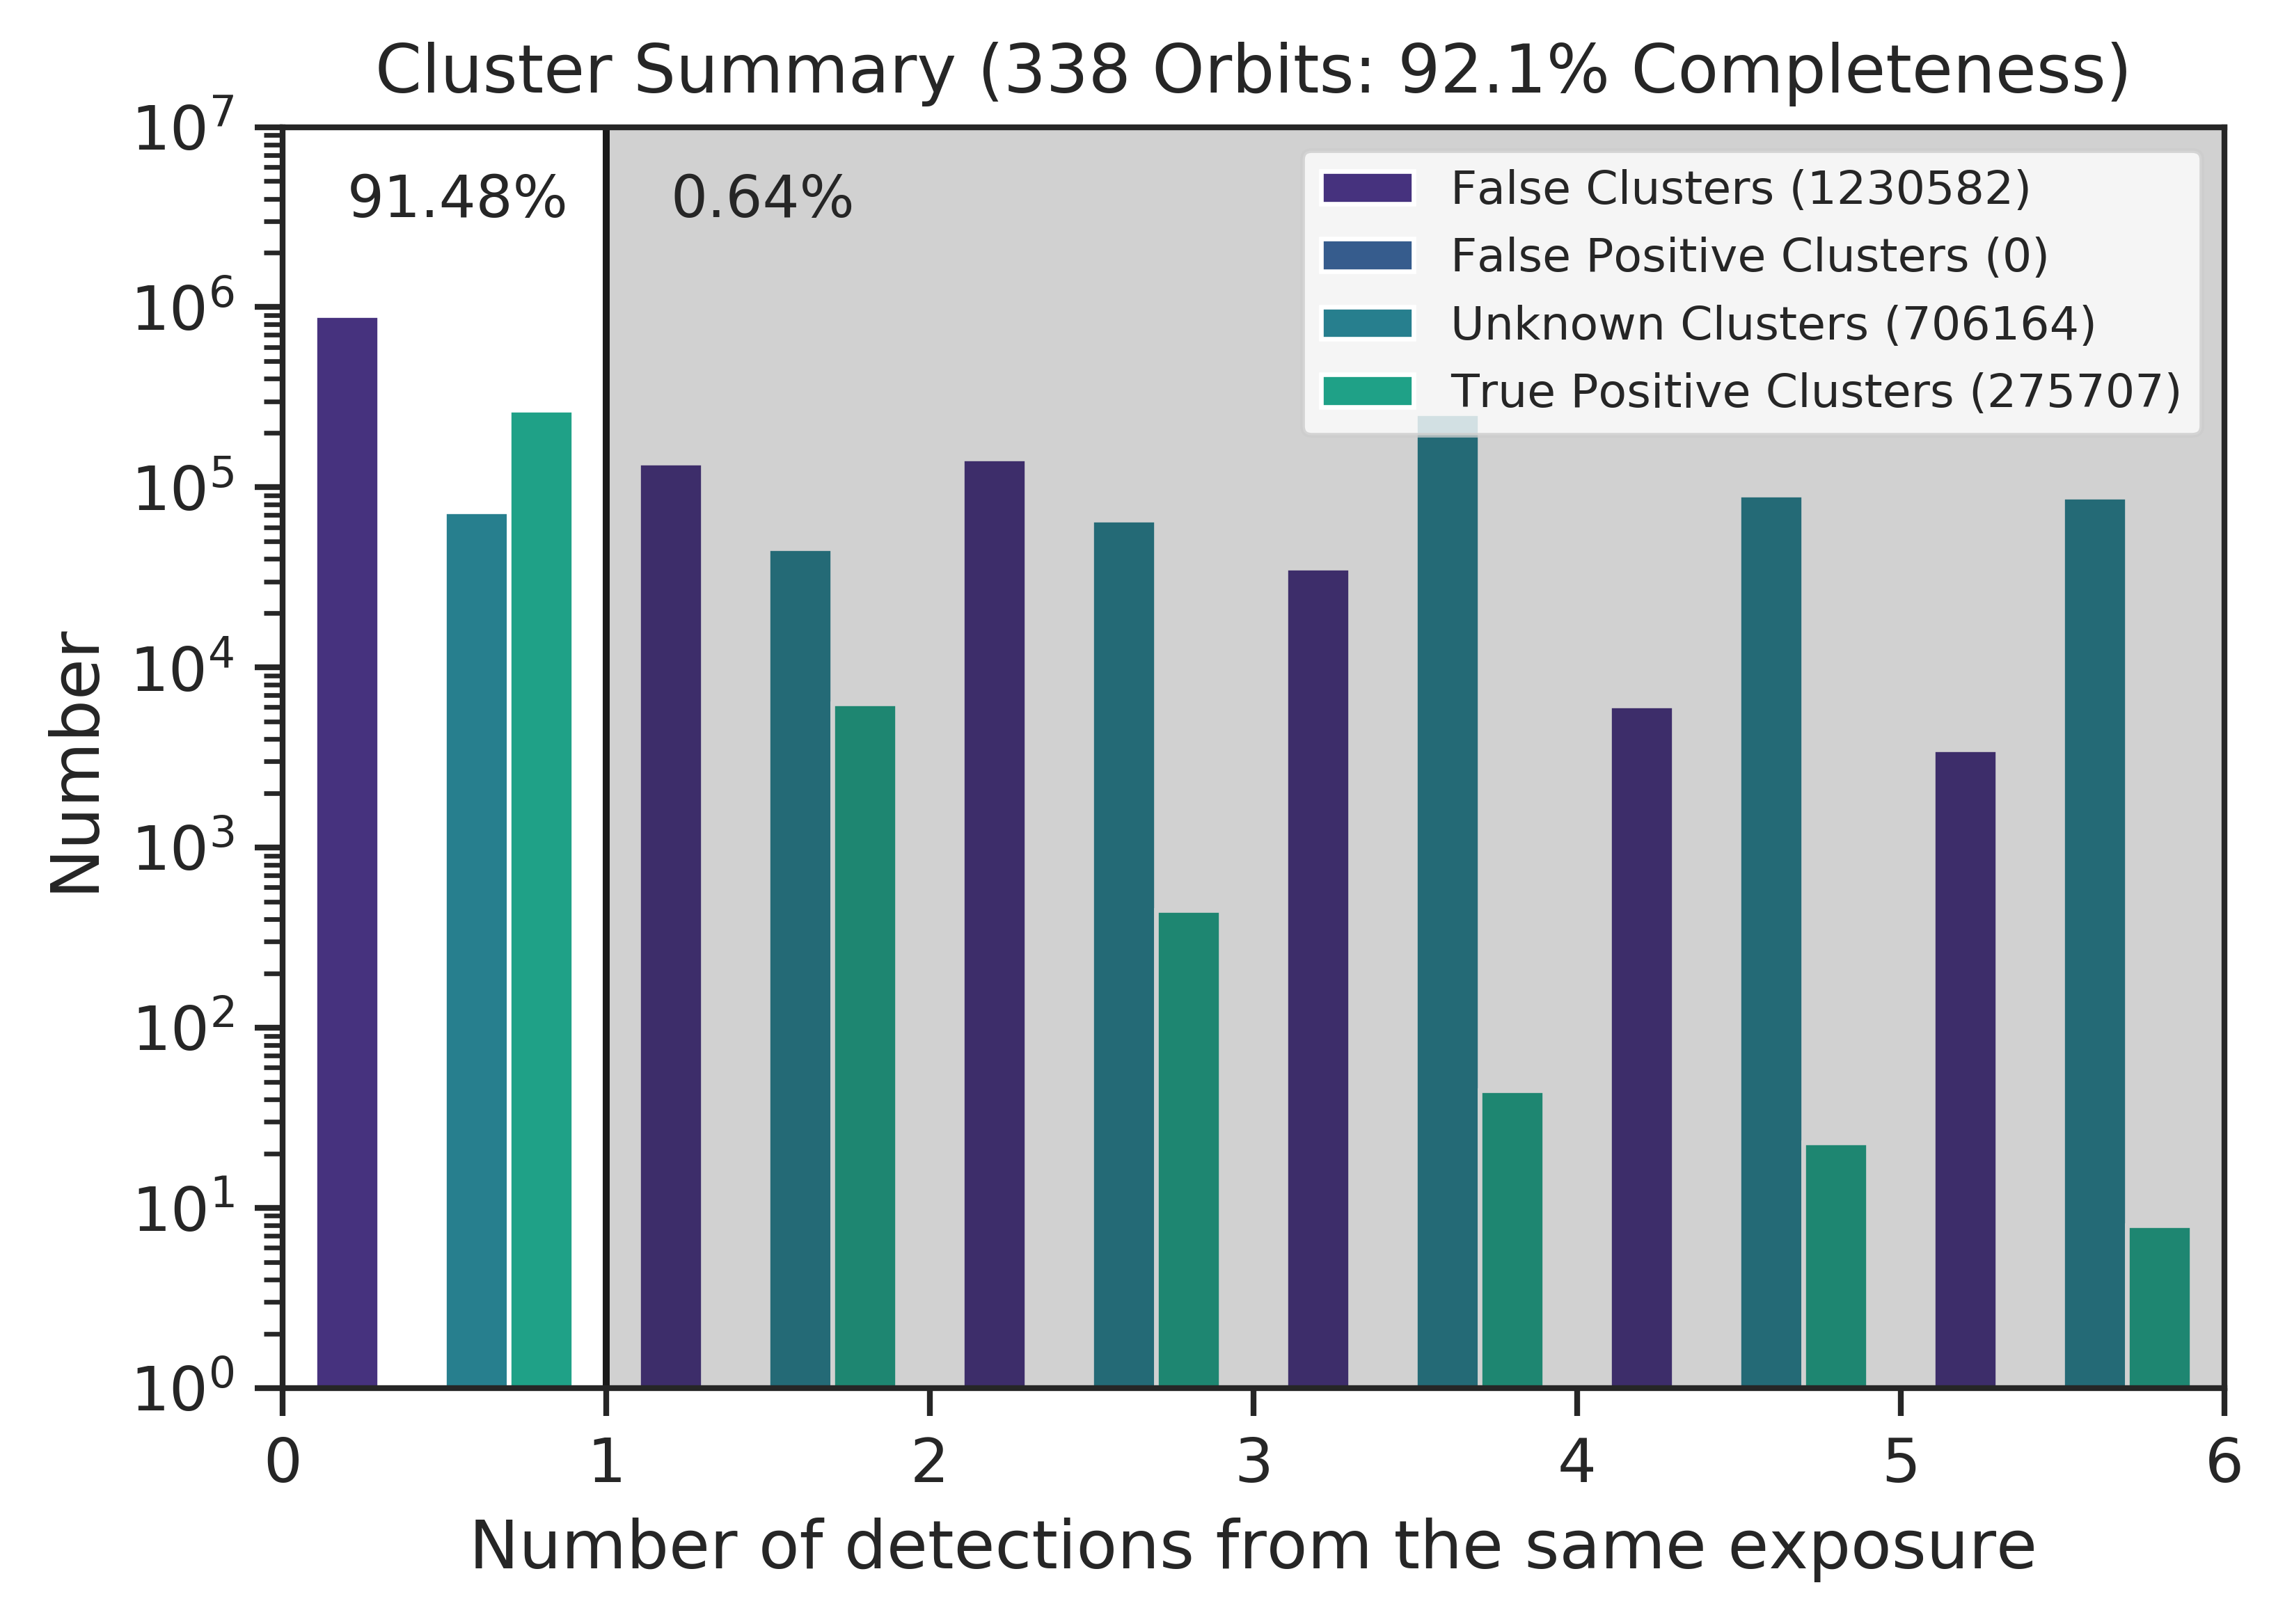

In [31]:
accepted_clusters = allClusters_projection[(~allClusters_projection["linked_object"].isna()) 
                                           & (~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs))]
a = set(accepted_clusters[accepted_clusters["num_dupes"] == 0]["linked_object"].unique())
b = set(accepted_clusters[accepted_clusters["num_dupes"] > 0]["linked_object"].unique())


fig, ax = plt.subplots(1, 1, dpi=600)
ax.hist([allClusters_projection[allClusters_projection["linked_object"].isna()]["num_dupes"].values, 
         allClusters_projection[allClusters_projection["linked_object"].isin(falsePositiveIDs)]["num_dupes"].values,
         allClusters_projection[allClusters_projection["linked_object"].isin(unknownIDs)]["num_dupes"].values,
         allClusters_projection[(~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs) & (~allClusters_projection["linked_object"].isna()))]["num_dupes"].values], 
        bins=range(7), 
        label=["False Clusters ({})".format(len(allClusters_projection[allClusters_projection["linked_object"].isna()])), 
               "False Positive Clusters ({})".format(len(allClusters_projection[allClusters_projection["linked_object"].isin(falsePositiveIDs)])),
               "Unknown Clusters ({})".format(len(allClusters_projection[allClusters_projection["linked_object"].isin(unknownIDs)])),
               "True Positive Clusters ({})".format(len(allClusters_projection[((allClusters_projection["partial"] == 1) | (allClusters_projection["pure"] == 1)) & (~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs))]))])
ax.legend(fontsize=8)
ax.set_xlabel("Number of detections from the same exposure")
ax.vlines(1, 1, 10**7)
ax.set_yscale("log")
ax.set_ylim(1, 10**7)
ax.text(0.2, 10**6.5, "{:0.2f}%".format(len(a) / 21401 * 100))
ax.text(1.2, 10**6.5, "{:0.2f}%".format(len(b.difference(a)) / 21401 * 100))
ax.axvspan(1, 6, color="k", alpha=0.2)
ax.set_xlim(0, 6)
ax.set_title("Cluster Summary (338 Orbits: 92.1% Completeness)")
ax.set_ylabel("Number")
fig.savefig("plots/cluster_summary_ztf.png")

In [32]:
len(observations) == (len(observations[observations["designation"].isna() | observations["designation"].isin(falsePositiveIDs + unknownIDs)])
                        + len(observations[~observations["designation"].isna() & ~observations["designation"].isin(falsePositiveIDs + unknownIDs)]))

True

In [33]:
len(allClusters_projection) == (len(allClusters_projection[allClusters_projection["linked_object"].isna() | allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs)])
                        + len(allClusters_projection[~allClusters_projection["linked_object"].isna() & ~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs)]))

True

In [34]:
observations[]

,ra,decl,field,nid,jd,exp_mjd,magpsf,sigmapsf,fid,ssnamenr,fieldRA_deg,fieldDec_deg,visit_id,mjd,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,obs_id,designation,splitname
4169,260.683004,-25.977852,280,610,2.458365e+06,58364.130486,18.0388,0.112068,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4170,-1,NaN
4627,260.801566,-23.783219,280,610,2.458365e+06,58364.130486,16.3064,0.052620,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4628,-1,NaN
4628,261.563832,-24.321873,280,610,2.458365e+06,58364.130486,13.9298,0.031140,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4629,-1,NaN
4629,254.228779,-20.646241,280,610,2.458365e+06,58364.130486,18.6277,0.138174,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4630,-1,NaN
4630,255.077762,-27.667873,280,610,2.458365e+06,58364.130486,14.6343,0.053508,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4631,-1,NaN
4631,255.471282,-27.693492,280,610,2.458365e+06,58364.130486,15.5643,0.079323,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4632,-1,NaN
4632,254.704683,-27.505541,280,610,2.458365e+06,58364.130486,18.4293,0.181175,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4633,-1,NaN
4633,253.780692,-27.096755,280,610,2.458365e+06,58364.130486,16.6758,0.093491,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4634,-1,NaN
4634,254.149563,-27.762260,280,610,2.458365e+06,58364.130486,17.4118,0.100169,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4635,-1,NaN
4635,254.307223,-21.041026,280,610,2.458365e+06,58364.130486,16.7807,0.074301,2,NaN,257.81886,-24.25,27,58364.130486,0.949951,-0.339590,0.000049,4636,-1,NaN


In [35]:
# Groupby night, then count number of occurences per night
night_designation_count = observations[~observations["designation"].isin(falsePositiveIDs + unknownIDs)].groupby(["nid"])["designation"].value_counts()
night_designation_count = pd.DataFrame(night_designation_count)
night_designation_count.rename(columns={"designation": "num_obs"}, inplace=True)
night_designation_count.reset_index(inplace=True)

In [43]:
test = observations[~observations["designation"].isin(falsePositiveIDs + unknownIDs) & observations["designation"].isin(["09816"])]

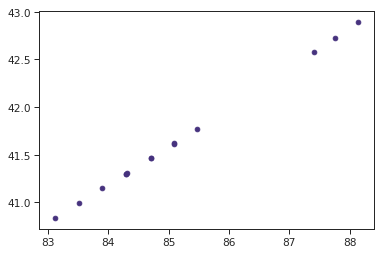

In [48]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*test[["ra", "decl"]].values.T)

In [77]:
obs_per_night = test["nid"].value_counts()
tracklet_nights = obs_per_night[obs_per_night >= 2].index.values

In [87]:
tracklet_nights

array([614, 616, 615])

In [98]:
obs_per_object = observations[(~observations["designation"].isna()) 
                              & (~observations["designation"].isin(falsePositiveIDs + unknownIDs))]["designation"].value_counts()
possibly_findable = obs_per_object[obs_per_object >= 4].index.values

27815

In [102]:
test = observations[observations["designation"].isin([possibly_findable[0]])]

In [103]:
test[]

,ra,decl,field,nid,jd,exp_mjd,magpsf,sigmapsf,fid,ssnamenr,fieldRA_deg,fieldDec_deg,visit_id,mjd,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,obs_id,designation,splitname
536644,341.413612,32.109401,692,610,2.458365e+06,58364.249826,19.7743,0.129308,1,453781,345.00678,33.35,2997,58364.249826,0.950631,-0.337654,0.000044,536645,j3781,453781
536763,341.408527,32.109863,692,610,2.458365e+06,58364.266204,19.6791,0.138827,1,453781,345.00678,33.35,2998,58364.266204,0.950724,-0.337387,0.000043,536764,j3781,453781
536805,341.407926,32.109931,692,610,2.458365e+06,58364.268079,19.6775,0.131921,1,453781,345.00678,33.35,2999,58364.268079,0.950734,-0.337357,0.000043,536806,j3781,453781
531254,341.401698,32.110490,691,610,2.458365e+06,58364.287685,19.7488,0.181816,1,453781,337.22300,33.35,2906,58364.287685,0.950844,-0.337037,0.000042,531255,j3781,453781
537047,341.401648,32.110561,692,610,2.458365e+06,58364.288148,19.6982,0.147870,1,453781,345.00678,33.35,3000,58364.288148,0.950847,-0.337029,0.000042,537048,j3781,453781
537399,341.395056,32.111149,692,610,2.458365e+06,58364.309132,19.1086,0.103814,2,453781,345.00678,33.35,3001,58364.309132,0.950964,-0.336687,0.000040,537400,j3781,453781
531310,341.394913,32.111158,691,610,2.458365e+06,58364.309595,19.1532,0.103824,2,453781,337.22300,33.35,2907,58364.309595,0.950966,-0.336679,0.000040,531311,j3781,453781
537471,341.394773,32.111173,692,610,2.458365e+06,58364.310069,19.1043,0.087810,2,453781,345.00678,33.35,3002,58364.310069,0.950969,-0.336671,0.000040,537472,j3781,453781
531354,341.394629,32.111199,691,610,2.458365e+06,58364.310532,19.1175,0.087220,2,453781,337.22300,33.35,2908,58364.310532,0.950971,-0.336664,0.000040,531355,j3781,453781
531364,341.393235,32.111329,691,610,2.458365e+06,58364.314942,19.1827,0.092537,2,453781,337.22300,33.35,2909,58364.314942,0.950996,-0.336592,0.000039,531365,j3781,453781


In [84]:
for tracklet_night in tracklet_nights:
    delta_night = test["nid"].values - tracklet_night

In [85]:
delta_night[delta_night > -3 % ]

array([-4, -3, -2, -1, -1, -1,  0,  0,  1,  1,  2,  7,  8,  9])

In [72]:
delta_night =  614 - test["nid"]

In [76]:
test["nid"]

562781    611
563089    612
563116    613
566689    614
563355    614
563487    614
563520    615
563741    615
563764    616
564076    616
566894    617
567153    622
567212    623
567391    624
Name: nid, dtype: int64

In [74]:
delta_night

562781     3
563089     2
563116     1
566689     0
563355     0
563487     0
563520    -1
563741    -1
563764    -2
564076    -2
566894    -3
567153    -8
567212    -9
567391   -10
Name: nid, dtype: int64

In [75]:
delta_night[(delta_night > 0) & (delta_night < 4)]

562781    3
563089    2
563116    1
Name: nid, dtype: int64

In [71]:
delta_night

562781    -3
563089    -2
563116    -1
566689     0
563355     0
563487     0
563520     1
563741     1
563764     2
564076     2
566894     3
567153     8
567212     9
567391    10
Name: nid, dtype: int64